In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [12]:
# loading each unnormalised dataset
subject_ids = [f"S{i}" for i in range(2, 18) if i not in [1, 12]]  
dfs = []

for sid in subject_ids:
    df = pd.read_csv(f"Processed WESAD Data/Processed_{sid}_data_unnormalised_new.csv")
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)
data

,Participant ID,Filtered EDA Mean,Filtered EDA Standard Deviation,SCL Mean,SCL Standard Deviation,SCR Mean,SCR Standard Deviation,HRV (RMSSD),HRV (SDNN),HR (bpm),TEMP Mean,TEMP Standard Deviation,TEMP Slope,TEMP Range,Label
0,2,1.319926,0.158933,1.311394,0.097091,0.048811,0.055282,227.981315,172.109971,85.243129,35.810000,0.022730,-0.000183,0.12,0
1,2,1.148486,0.123709,1.154106,0.116166,0.023503,0.031501,212.441958,170.307538,79.455212,35.768000,0.049322,-0.000651,0.21,0
2,2,0.969361,0.161578,0.967142,0.149690,0.011604,0.015669,184.233470,152.013695,78.617389,35.719333,0.036600,-0.000422,0.15,0
3,2,0.780818,0.099444,0.784546,0.106375,0.004581,0.006427,159.404043,153.345582,78.572928,35.708333,0.023464,0.000215,0.09,0
4,2,0.656155,0.073471,0.654764,0.072738,0.004088,0.006014,125.189743,136.537417,74.573025,35.744167,0.038828,0.000520,0.17,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,17,1.085934,0.014432,1.085905,0.004904,0.003564,0.010046,107.596426,98.159150,125.852124,32.333167,0.070699,0.000994,0.27,1
1100,17,1.083978,0.007285,1.084305,0.005482,0.001510,0.003488,118.036298,116.497528,119.685699,32.427667,0.063715,0.000900,0.24,1
1101,17,1.075400,0.008162,1.075364,0.006820,0.001835,0.004210,152.322806,126.263518,112.021025,32.530750,0.076981,0.001091,0.26,1
1102,17,1.065623,0.011943,1.064553,0.008547,0.003008,0.004770,160.252394,131.740600,108.012618,32.616167,0.055230,0.000719,0.22,1


In [13]:
# defining features
feature_col = ['HR (bpm)', 'HRV (RMSSD)', 'HRV (SDNN)', 'Filtered EDA Mean', 'Filtered EDA Standard Deviation', 'SCL Mean', 'SCL Standard Deviation', 'SCR Mean', 'SCR Standard Deviation', 'TEMP Mean', 'TEMP Standard Deviation', 'TEMP Slope', 'TEMP Range']

# defining X and y
X = data[feature_col]
y = data['Label']
groups = data['Participant ID']

# just checking class imbalance
y.value_counts(normalize=True)

Label
0    0.637681
1    0.362319
Name: proportion, dtype: float64

In [14]:
logo = LeaveOneGroupOut()
scaler = StandardScaler()
accuracy = []
f1_list = []
subject_scores = []

all_y_true = []
all_y_pred = []

coeff_list = []

for train_idx, test_idx in logo.split(X, y, groups):
    subj_id = groups.iloc[test_idx].unique()[0]  
    
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # normalising
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # training and predicting
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    subject_scores.append({
        "Subject": subj_id,
        "Accuracy": acc,
        "F1 Score": f1
    })

    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

    coeff_list.append(model.coef_[0])

In [15]:
subject_scores_df = pd.DataFrame(subject_scores)
subject_scores_df.sort_values(by="Accuracy")

,Subject,Accuracy,F1 Score
1,3,0.458333,0.465753
2,4,0.549296,0.589744
12,15,0.640000,0.658228
0,2,0.671429,0.148148
7,9,0.675676,0.142857
13,16,0.702703,0.710526
6,8,0.739726,0.457143
10,13,0.767123,0.753623
5,7,0.851351,0.825397
11,14,0.866667,0.772727


In [16]:
accuray = subject_scores_df['Accuracy'].mean()
f1_score_mean = subject_scores_df['F1 Score'].mean()
print(f'Accuracy = {accuray}')
print(f'F1 Score = {f1_score_mean}')

Accuracy = 0.775272560151598
F1 Score = 0.6731005683429816


<Figure size 600x600 with 0 Axes>

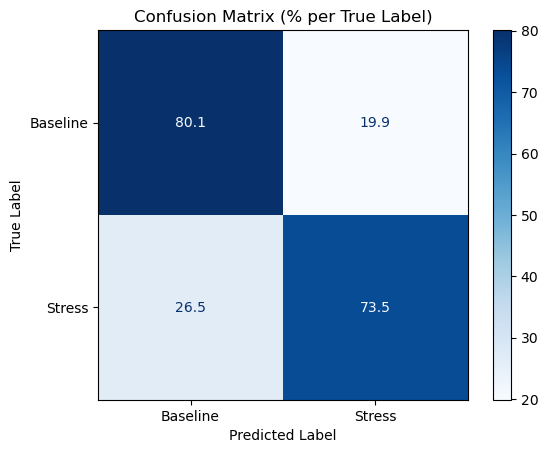

In [17]:
cm = confusion_matrix(all_y_true, all_y_pred)

row_sums = cm.sum(axis=1, keepdims=True)
cm_percent = (cm / row_sums) * 100  
cm_percent_rounded = np.round(cm_percent, 1)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent_rounded, display_labels=["Baseline", "Stress"])

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='0.1f')
plt.title("Confusion Matrix (% per True Label)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [18]:
coeff_array = np.vstack(coeff_list)  
mean_coeffs = coeff_array.mean(axis=0)

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': mean_coeffs,
    'Absolute Importance': np.abs(mean_coeffs)
}).sort_values(by='Absolute Importance', ascending=False)

importance_df

,Feature,Coefficient,Absolute Importance
0,HR (bpm),1.521085,1.521085
8,SCR Standard Deviation,1.315500,1.315500
11,TEMP Slope,-1.241829,1.241829
10,TEMP Standard Deviation,-0.991660,0.991660
1,HRV (RMSSD),0.981544,0.981544
9,TEMP Mean,-0.909811,0.909811
4,Filtered EDA Standard Deviation,-0.561879,0.561879
2,HRV (SDNN),-0.471269,0.471269
7,SCR Mean,0.468280,0.468280
12,TEMP Range,0.404316,0.404316


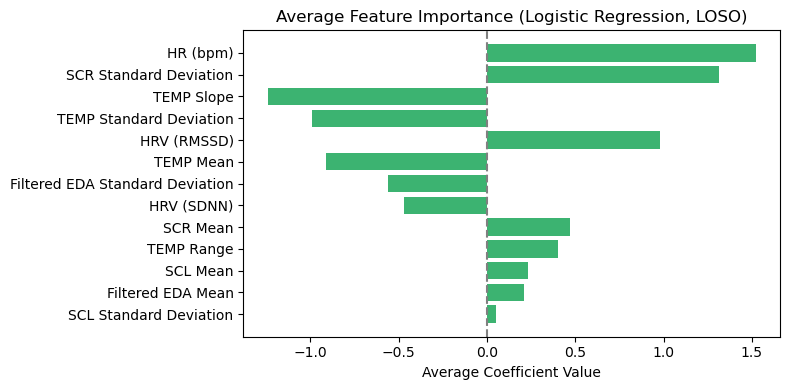

In [19]:
plt.figure(figsize=(8, 4))
plt.barh(importance_df['Feature'], importance_df['Coefficient'], color='mediumseagreen')
plt.xlabel('Average Coefficient Value')
plt.title('Average Feature Importance (Logistic Regression, LOSO)')
plt.axvline(0, color='gray', linestyle='--')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()